In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import jax.numpy as jnp
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os, sys
from pathlib import Path
import tifffile as tf
from cmm import cmm
from importlib import reload
pl.style.use('dark_background')
sys.path.append('/groups/ahrens/home/ruttenv/code/zfish/')
from zfish.util import filesys as fs
from zfish.nir import cardio as ca
import zarr
from time import time
import matplotlib as mpl
from types import SimpleNamespace  
reload(cmm)
# matplotlib.pyplot.rc('text', usetex=True)
reload(cmm)
import jax
import jax.numpy as jnp

# Global flag to set a specific platform, must be used at startup.
jax.config.update("jax_platform_name", "cpu")

mpl.style.use('dark_background')

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [3]:
base_dir = '/nrs/ahrens/Virginia_nrs/behavior_rig_flow/230304_f474_9dpf_casper/'
fnum = fs.get_fnum(base_dir)
print(f'fnum: {fnum}')

exp = 0
dirs_ = fs.get_subfolders(base_dir)
folder_path = dirs_[f'exp{exp}']
dirs = fs.get_subfolders(folder_path)
os.makedirs(dirs['main'] + 'cmm', exist_ok=True)
dirs = fs.get_subfolders(folder_path)
plotpath = dirs['cmm'] + 'plots/'

fnum: 474


In [32]:
fpaths = glob(dirs["cmm"] + '/results/*.npy')
print(fpaths)
ind = 3
print(fpaths[ind])
if len(fpaths)>0:
    r = np.load(fpaths[ind], allow_pickle = True).item()
# cm = SimpleNamespace(**r)

['/nrs/ahrens/Virginia_nrs/behavior_rig_flow/230304_f474_9dpf_casper/exp0/cmm//results/run.npy', '/nrs/ahrens/Virginia_nrs/behavior_rig_flow/230304_f474_9dpf_casper/exp0/cmm//results/run_loop.npy', '/nrs/ahrens/Virginia_nrs/behavior_rig_flow/230304_f474_9dpf_casper/exp0/cmm//results/run_loop2.npy', '/nrs/ahrens/Virginia_nrs/behavior_rig_flow/230304_f474_9dpf_casper/exp0/cmm//results/run_loop3_freqlim.npy', '/nrs/ahrens/Virginia_nrs/behavior_rig_flow/230304_f474_9dpf_casper/exp0/cmm//results/run_m10.npy']
/nrs/ahrens/Virginia_nrs/behavior_rig_flow/230304_f474_9dpf_casper/exp0/cmm//results/run_loop3_freqlim.npy


In [33]:
impath = glob(dirs["imag_crop"] + "*.tif")[0]
imzarr = tf.imread(impath, aszarr=True)
im = zarr.open(imzarr, mode="r")[: 15*30]
t, x, y = im.shape
xnt = im.reshape([t, -1]).T

In [55]:
reload(utils)
reload(cmm)

fps = 0.3
nperseg = int(fps * 200)
noverlap = int(0.6 * nperseg)
freq_minmax = [-np.inf, np.inf]
freq_minmax = [0, 0.05]
opt_in_freqdom = True
print(f'nperseg: {nperseg}')
m = 20
t0 = time()
cm = cmm.CMM(
    xnt,
    m=m,
    fs=fps,
    nperseg=nperseg,
    noverlap=noverlap,
    freq_minmax=freq_minmax,
    opt_in_freqdom=opt_in_freqdom,
)

cm.optimize(1)
t1 = time()
tt = int(t1 - t0)
print(f"time: {tt}")


nperseg: 60
31 (31,) (17, 450, 31)
31 (31,) (17, 450, 31)
at ite: 0, time: 0.0mins
time: 2


In [57]:
cm.freqs.shape

(4,)

In [58]:
cm.nperseg

60

In [35]:
r.keys()

dict_keys([10])

In [ ]:
sil = []
for i in r.keys():
    sil.append((i, r[i]['silhouette']))
sil = np.array(list(zip(sil))).squeeze()

In [ ]:
pl.figure(figsize = (10, 3))
pl.plot(sil[:,0], sil[:,1],'o-')
pl.xlabel('cluster #')
pl.ylabel('silhouette')

In [41]:
vals = list(r.keys())
cm = SimpleNamespace(**r[vals[0]]['r'])

In [43]:
np.unique(cm.labels, return_counts= True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([575, 466, 754, 678, 682, 470, 504, 655, 438, 378]))

In [44]:
indices = [np.argwhere(cm.labels ==i).squeeze() for i in np.unique(cm.labels)]
cluster_coherence_m2f = cmm.compute_cluster_coherence(cm.coherence_mnf, cm.labels)
order = np.argsort(cluster_coherence_m2f[:,:,5:].max(axis = -1)[:,0])[::-1]

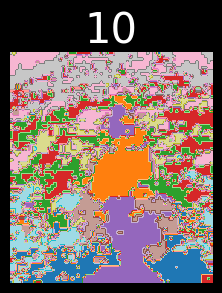

In [45]:
for d in list(r.keys()):
    cm = SimpleNamespace(**r[d]['r'])
    pl.figure()
    pl.imshow(cm.labels.reshape([x,y]), cmap='tab20')
    pl.axis('off')
    pl.title(d)

In [46]:
coherence_im_mf = cm.coherence_mnf.reshape([cm.m, x, y, -1]).transpose([0,3,1,2])
angles_mkfxy, angles_mfxy_mean, angles_mfxy_std = cmm.compute_average_phase_shift(cm.coefs_xnkf, cm.coefs_ymkf, x = x, y = y)
labels_im = cm.labels.reshape([x, y])


In [47]:
def weight_image(angles, coherence, thresh):
    tmp = angles.copy()
    tmp[coherence<thresh] = np.nan
    return tmp
k, f = angles_mkfxy.shape[1:3]
thresh = 0.8
weighted_angles_mfxy_mean = np.nanmean(weight_image(angles_mfxy_mean, coherence_im_mf, thresh), axis = -1)
weighted_angles_mfxy_std = np.nanmean(weight_image(angles_mfxy_std, coherence_im_mf, thresh), axis = -1)/np.sqrt(k)
abs_fxy_std = np.std(np.abs(cm.coefs_xnkf), axis = 1).reshape([x, y, f]).transpose([2,0,1])

/tmp/ipykernel_2152293/3729857060.py:7: RuntimeWarning: Mean of empty slice
  weighted_angles_mfxy_mean = np.nanmean(weight_image(angles_mfxy_mean, coherence_im_mf, thresh), axis = -1)
/tmp/ipykernel_2152293/3729857060.py:8: RuntimeWarning: Mean of empty slice
  weighted_angles_mfxy_std = np.nanmean(weight_image(angles_mfxy_std, coherence_im_mf, thresh), axis = -1)/np.sqrt(k)


In [48]:
# ksize = 1
# tmp = angles_mfxy_mean[order[i],ff][::-1].T
# gX = cv2.Sobel(-tmp, ddepth =cv2.CV_32F,  dx=0, dy=1, ksize=ksize)
# pl.imshow(gX, cmap = 'gray')
# pl.figure()
# pl.imshow(tmp)

In [52]:
cm.freq[35]

0.8764607679465777

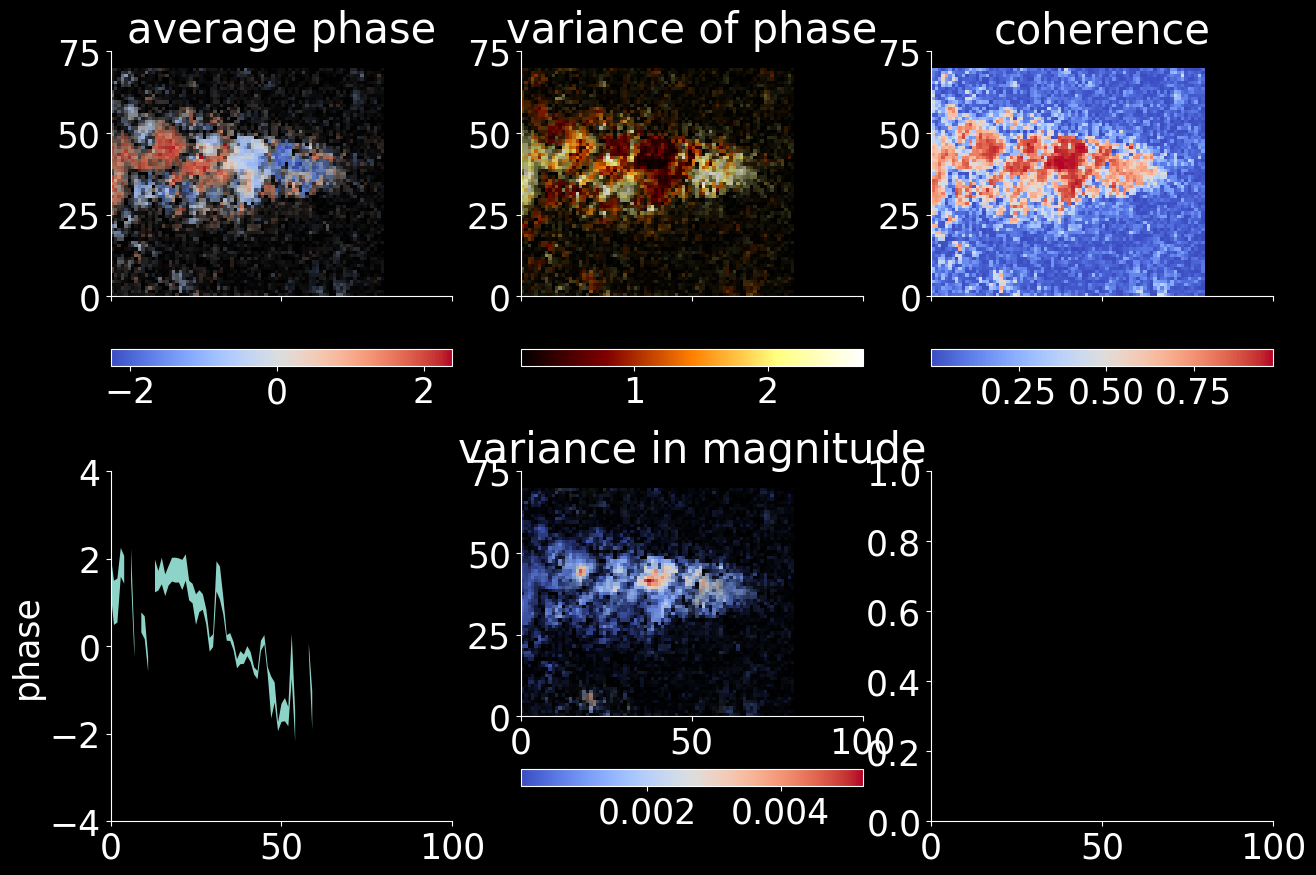

In [49]:
i = 0
ff = 35
alpha = coherence_im_mf[order[i],ff]
fig, axs = pl.subplots(nrows = 2, ncols = 3, sharex = True, figsize = (15, 10))
im0 = axs[0,0].pcolormesh(angles_mfxy_mean[order[i],ff][::-1].T, cmap = 'coolwarm', alpha = alpha[::-1].T)
im1 = axs[0,1].pcolormesh(angles_mfxy_std[order[i],ff][::-1].T, cmap = 'afmhot', alpha = alpha[::-1].T)
m = weighted_angles_mfxy_mean[order[i],ff][::-1]
st = weighted_angles_mfxy_std[order[i],ff][::-1]
axs[1,0].fill_between(np.arange(x), m + st, m-st)

im3 = axs[1,1].pcolormesh(abs_fxy_std[ff][::-1].T, cmap = 'coolwarm', alpha = alpha[::-1].T)
im2 = axs[0,2].pcolormesh(coherence_im_mf[order[i],ff][::-1].T, cmap = 'coolwarm')
levels = 10
# axs[0,2].contour(X, Y, coherence_im_mf[order[ind],ff].reshape([x,y])[::-1].T, \
#                  alpha = 1,  cmap = 'coolwarm',levels = levels)
# axs[1,2].contour(X, Y, angles_mfxy_mean[order[i],ff][::-1].T, alpha = 1)

axs[0,0].set_title('average phase')
axs[0,1].set_title('variance of phase')
axs[1,1].set_title('variance in magnitude')
axs[0,2].set_title('coherence')
axs[1,0].set_ylabel('phase')
# [axs[0,i].axis('off') for i in range(2)]
divider = make_axes_locatable(axs[0,0])
divider = make_axes_locatable(axs[0,1])
divider = make_axes_locatable(axs[0,2])
divider = make_axes_locatable(axs[1,1])
fig.colorbar(im0, ax=axs[0,0], orientation='horizontal')
fig.colorbar(im1, ax=axs[0,1], orientation='horizontal')
fig.colorbar(im2, ax=axs[0,2], orientation='horizontal')
fig.colorbar(im3, ax=axs[1,1], orientation='horizontal')

ind = 0
ff = 35
xa = np.arange(x)
ya = np.arange(y)
X, Y = np.meshgrid(xa, ya)
# fig, ax = pl.subplots()


pl.savefig(plotpath + '0 - phase ana')

In [ ]:
m, k, f = cm.coefs_ymkf.shape
cross_coefs_mnkf = (cm.coefs_xnkf[None]*np.conj(cm.coefs_ymkf[:,None]))
cross_coefs_mnf_mean = np.mean(np.angle(cross_coefs_mnkf), axis = 2).reshape([m, x, y, f]).transpose([0,3,1,2])
cross_coefs_mnf_std= np.std(np.angle(cross_coefs_mnkf), axis = 2).reshape([m, x, y, f]).transpose([0,3,1,2])
weighted_cross_coefs_mnf_std = (cross_coefs_mnf_std*tmp).mean(3)
weighted_cross_coefs_mnf_mean = (cross_coefs_mnf_mean*tmp).mean(3)

In [ ]:
# pl.imshow(cross_coefs_mnf_mean[order[0],35][::-1].T)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
i = 1
ff = 35
alpha = coherence_im_mf[order[i],ff]
fig, axs = pl.subplots(nrows = 2, ncols = 2, sharex = True, figsize = (12, 12))
im0 = axs[0,0].pcolormesh(angles_im_mf[order[i],ff][::-1].T, cmap = 'coolwarm', alpha = alpha[::-1].T)
im1 = axs[0,1].pcolormesh(cross_coefs_mnf_std[order[i],ff][::-1].T, cmap = 'afmhot', alpha = alpha[::-1].T)
# axs[1,0].plot(weighted_angleline_mf[order[i],ff][::-1])
axs[1,0].plot(weighted_cross_coefs_mnf_mean[order[i],ff][::-1])
axs[1,1].plot(weighted_cross_coefs_mnf_std[order[i],ff][::-1])
[axs[0,i].axis('off') for i in range(2)]
divider = make_axes_locatable(axs[0,0])
divider = make_axes_locatable(axs[0,1])
fig.colorbar(im0, ax=axs[0,0], orientation='horizontal')
fig.colorbar(im1, ax=axs[0,1], orientation='horizontal')
    
# pl.imshow(np.angle(weighted_im_mf)[order[ind],ff].T)
# pl.colorbar()
# pl.hist(angles_im_mf[order[0], ff][labels_im == order[ind]], bins = 40);

In [ ]:
pl.plot(weighted_line_mf[order[0],ff])

In [ ]:
# i = 4
# ff = 35
# alpha = coherence_im_mf[i,ff]
# pl.imshow(np.diff(angles_im_mf[i,ff], axis = 1), cmap = 'coolwarm', alpha = alpha)
# pl.colorbar()
# pl.clim([-20,20])

In [ ]:
cmap = pl.get_cmap('plasma')
ind = 0
pl.figure(figsize = (21, 3))
for i, ind in enumerate(order):
    pl.plot(cm.freq, cm.coherence_mnf[order[ind],indices[ind]].mean(0),'-', label = ind, alpha = .8, color = cmap(1-i/cm.m))
pl.legend(fontsize = 10)
pl.ylabel('coherence')
pl.xlabel('frequency [Hz]')
# pl.savefig(plotpath + 'spectra', transparent = True, bbox_inches = 'tight')

pl.figure()
pl.title('clusters')
pl.imshow(cm.labels.reshape([x, y]), interpolation=None, cmap = 'tab20')
pl.axis('off')
pl.colorbar()
pl.savefig(plotpath + 'labels', transparent = True, bbox_inches = 'tight')


In [ ]:
impath = glob(dirs['imag_crop'] + '*.tif')[0]
im = tf.imread(impath)
dt, dx, dy = im.shape 
fps = 15.0
nperseg = int(fps*20)
noverlap = int(0.8*nperseg)
freq_minmax = [-np.inf, np.inf]
# freq_minmax = [1,4]

In [ ]:
pl.title('raw')
pl.imshow(im[10], cmap = 'gray')
pl.axis('off')
pl.show()

In [ ]:
xnt = im.reshape([dt, dx*dy]).T

In [ ]:
reload(cmm)
opt_in_freqdom = True
k = 10
cm = cmm.CMM(
    xnt.astype('float32'),
    k=k,
    fs=fps,
    nperseg=nperseg,
    noverlap=noverlap,
    freq_minmax=freq_minmax,
    opt_in_freqdom=opt_in_freqdom,
)

In [ ]:
cm.optimize(100)

In [ ]:
# cm.analyse_results()

In [ ]:
coherence_mnf = cm.compute_cross_coherence_from_coefs(
            cm.coefs_ymkf, cm.coefs_xnkf)
labels_unique, labels_count = np.unique(cm.labels, return_counts=True)
indices = [np.argwhere(cm.labels ==i).squeeze() for i in labels_unique]
cluster_coherence = cm.compute_cluster_coherence(coherence_mnf, cm.labels)
order = np.argsort(cluster_coherence[:,:,5:].max(axis = -1)[:,0])[::-1]

In [ ]:
ymtf = jnp.einsum("mkf,ktf->mtf", cm.coefs_ymkf, cm.valid_iDFT_Wktf).real
xntf = jnp.einsum("mkf,ktf->mtf", cm.coefs_xnkf, cm.valid_iDFT_Wktf).real

In [ ]:
xmean = xnt[indices[0]]
pxf, freqs = cm.estimate_spectrum(xmean, x_in_coefs=False)
print(pxf.shape)
pl.plot(freqs[2:], pxf[:,2:].T,'.-');

In [ ]:
cmap = pl.get_cmap('plasma')
ind = 0
for i, ind in enumerate(order):
    pl.plot(cm.freq, coherence_mnf[order[ind],indices[ind]].mean(0),'-', label = ind, alpha = .8, color = cmap(1-i/cm.k))
pl.legend(fontsize = 10)
pl.ylabel('coherence')
pl.xlabel('frequency [Hz]')
pl.savefig(dirs['cmm'] + 'spectra', transparent = True, bbox_inches = 'tight')

pl.figure()
pl.title('clusters')
pl.imshow(cm.labels.reshape([dx, dy]), interpolation=None, cmap = 'tab20')
pl.axis('off')
pl.colorbar()
pl.savefig(dirs['cmm'] + 'labels', transparent = True, bbox_inches = 'tight')

In [ ]:
pl.figure(figsize = (5,5))
pl.plot(np.abs(cm.coefs_xnkf[indices[1]]).mean(0)[:,ff],np.abs(cm.coefs_xnkf[indices[2]]).mean(0)[:,ff],'o')

In [ ]:
sl = slice(int(fps*50),int(fps*300))
pl.figure(figsize = (5,5))
# pl.plot(xnt[indices[order[1]]].mean(0)[sl],xnt[indices[order[2]]].mean(0)[sl])
ff = 35
pl.plot(xntf[indices[order[1]],:,ff].mean(0)[sl], xntf[indices[order[2]],:,ff].mean(0)[sl],'-', alpha = 1)

In [ ]:
angles_mnf.shape

In [ ]:
angles_mnf = cm.compute_average_phase_shift(cm.coefs_xnkf, cm.coefs_ymkf)

In [ ]:
cluster_coherence = cm.compute_cluster_coherence(coherence_mnf, cm.labels)
cluster_coherence_thresh = cluster_coherence.copy()
thresh = 0.5
cluster_coherence_thresh[cluster_coherence_thresh<thresh] = 0
cluster_coherence_thresh[:,:,cm.freq>2] = 0

In [ ]:
pl.plot(np.abs(cm.coefs_xnkf[indices[0],:,10]).mean(0))

In [ ]:
sl = slice(int(fps*50),int(fps*100))
# tmp = cm.eigvals_mf.copy()
# tmp[:,40:] = 10
# tmp[:,:20] = 1
ind = 0
tmp = cluster_coherence_thresh[order[ind],0]
ymt_ = cm.backproject(cm.coefs_ymkf*tmp[None,None]).sum(-1)
# ymt_2 = cm.backproject(cm.coefs_ymkf*tmp[order[-1],None].mean()).mean(-1)
# cm.coefs_ymkf.shape, cm.eigvals_kf.shape
pl.figure()
pl.plot(ymt_[order[ind],sl].T);
pl.plot(ymtf[order[ind],sl,30].T);
# pl.plot(ymt_2[order[0],sl].T);





In [ ]:
# sl = slice(int(fps*10),int(fps*120))
# pl.plot(xnt[indices[0]].mean(0)[sl])

In [ ]:
# pl.plot(coherence_mnf[0, indices[0]].max(0)[2:])
# pl.plot(cm.freq[10],coherence_mnf[0].mean(0)[10],'o')

In [ ]:
# for i in range(cm.k):
#     pl.figure()
#     pl.title(i)
#     pl.plot(xntf[indices[i]].mean(0)[:,10][sl])
# #     pl.plot(xntf[indices[i]].mean(0)[:,35][sl])
#     pl.ylim([-0.9, 0.9])

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
coherence_im_mf = coherence_mnf.reshape([cm.k, dx, dy, -1]).transpose([0,3,1,2])
angles_im_mf = np.rad2deg(angles_mnf.reshape([cm.k, dx, dy, -1]).transpose([0,3,1,2]))
ff = 35
for i in range(cm.k):
    fig, axs = pl.subplots(ncols = 2, figsize = (10, 5))
    pl.title(i)
    
    im_ = axs[0].imshow(coherence_im_mf[i,ff], cmap = 'coolwarm')
    divider = make_axes_locatable(axs[0])
    fig.colorbar(im_, ax=axs[0], orientation='vertical')
    axs[0].axis('off')
    axs[1].axis('off')
    alpha = coherence_im_mf[i,ff]
    axs[1].imshow(angles_im_mf[i,ff], cmap = 'coolwarm', alpha = alpha)
#     pl.savefig(dirs['cmm'] + f'phase {ff} cluster {i}', transparent = True, bbox_inches = 'tight')

In [ ]:
ff = 35
ind = 0

alpha = coherence_mnf[order[ind], :,ff].reshape([dx, dy])
pl.figure()
pl.title('phase')
pl.imshow(angles_im_mf[order[ind],ff], cmap = 'coolwarm', alpha = alpha)
pl.colorbar()
pl.axis('off')
pl.savefig(dirs['cmm'] + f'phase {ff} cluster {ind}', transparent = True, bbox_inches = 'tight')

In [ ]:
xnt[indices[order[0]]]

In [ ]:
# pl.plot(freqs[2:], pxf[0][2:],'o')

In [ ]:
# sl = slice(int(fps*10),int(fps*50))
# pl.plot(xnt.mean(0)[sl])

In [ ]:
print(order)

In [ ]:
pl.plot(cm.eigvals_kf[order[0]])
pl.plot(cm.eigvals_kf[order[-1]])


In [ ]:
# pl.pcolormesh(np.abs(cm.coefs_ymkf)[order[2]])
# pl.colorbar()
# pl.figure()
# pl.plot()

In [ ]:
tmp = cm.eigvals_kf.copy()
tmp-=tmp.min(axis = -1)[:,None]

In [ ]:
tmp[order[0],None].shape

In [ ]:
tmp = cm.eigvals_kf.copy()
tmp[:,40:] = 10
tmp[:,:20] = 1
ymt_ = cm.backproject(cm.coefs_ymkf*tmp[order[0],None,None]).mean(-1)
ymt_2 = cm.backproject(cm.coefs_ymkf*tmp[order[-1],None].mean()).mean(-1)
# cm.coefs_ymkf.shape, cm.eigvals_kf.shape

pl.figure()
pl.plot(ymt_[order[0],sl].T);
# pl.plot(ymt_2[order[0],sl].T);


pl.figure()
pl.plot(ymt_[order[-1],sl].T);


In [ ]:
# pl.plot((np.abs(cm.coefs_ymkf*cm.eigvals_kf[:,None])**2).sum(1)[order[0]])

In [ ]:

pl.plot(ymtf_[order[0]][sl].mean(-1))
pl.figure()
pl.plot(ymtf[order[0]][sl].mean(-1))

In [ ]:
pl.plot(cm.eigvals_kf[order[0]])

In [ ]:
# sl = slice(int(fps*10),int(fps*120))
# pl.plot(xntf.sum(-1).mean(0)[sl])
# sl = slice(int(fps*20),int(fps*50))
# for i in order:
#     pl.figure()
#     pl.title(i)
#     inds = np.argwhere(cm.labels == i).squeeze()
#     pl.plot(xntf[inds].sum(-1).mean(0)[sl])

In [ ]:
for i in order[:4]:
    pl.figure()
    pl.title(i)
    inds = np.argwhere(cm.labels == i).squeeze()
    pl.plot(xnt[inds,].mean(axis = (0))[int(fps*5):int(fps*20)])

In [ ]:
for i in np.argsort(labels_count)[:3]:
    pl.figure()
    pl.title(i)
    inds = np.argwhere(cm.labels == i).squeeze()
    pl.plot(xntf[inds,].mean(axis = (0)).sum(1)[nperseg*2 +int(fps*5):nperseg*2 +int(fps*20)])

In [ ]:
_, labels_count = np.unique(cm.labels, return_counts=True)
for i in np.argsort(labels_count)[:1]:
    pl.figure()
    pl.title(i)
    inds = np.argwhere(cm.labels == i).squeeze()
    pl.plot(cm.xntf[inds,].mean(axis = (0)).sum(1)[nperseg*2 +int(fps*5):nperseg*2 +int(fps*20)])

In [ ]:
# cm.analyse_results()

In [ ]:
xntf

In [ ]:
_, labels_count = np.unique(cm.labels, return_counts=True)
for i in np.argsort(labels_count)[:1]:
    pl.figure()
    pl.title(i)
    inds = np.argwhere(cm.labels == i).squeeze()
    pl.plot(xntf[inds,].mean(axis = (0)).sum(1)[nperseg*2 +int(fps*5):nperseg*2 +int(fps*20)])

In [ ]:
for i in np.argsort(labels_count)[:1]:
    pl.figure()
    pl.title(i)
    inds = np.argwhere(cm.labels == i).squeeze()
    pl.plot(ymtf[i,:,40:60].sum(1)[nperseg*2 +int(fps*5):nperseg*2 +int(fps*20)])

In [ ]:
for i in np.argsort(labels_count)[:1]:
    pl.figure()
    pl.title(i)
    inds = np.argwhere(cm.labels == i).squeeze()
    pl.plot(xntf[inds,].mean(axis = (0)).sum(1)[nperseg*2 +int(fps*5):nperseg*2 +int(fps*20)])

In [ ]:
for i in np.argsort(labels_count):
    pl.figure()
    pl.title(i)
    inds = np.argwhere(cm.labels == i).squeeze()
    pl.plot(xnt[inds,].mean(axis = (0))[int(fps*5):int(fps*20)])

### plot results

In [ ]:
pl.imshow(cm.labels.reshape([dx, dy]), interpolation=None, cmap = 'tab20')
pl.colorbar()

In [ ]:
pl.plot(cm.kmeans_init_mt[5][:fs*4])

In [ ]:
pl.imshow(cm.labels_init.reshape([dx, dy]), interpolation=None)